# Bayesian MNIST CNN

#### References
* [Bayesian CNN with Tensorflow](https://medium.com/python-experiments/bayesian-cnn-model-on-mnist-data-using-tensorflow-probability-compared-to-cnn-82d56a298f45)
* [Tensorflow CNN](https://www.tensorflow.org/tutorials/images/cnn)
* [Tensorflow Probability Sample](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py)
* [Sample but with Issue](https://github.com/tensorflow/probability/issues/511)

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import datetime
import os
from tensorflow import keras
EPOCHS = 5
BATCH_SIZE = 64

print('Tensorflow version:', tf.__version__, 'eagerMode:', tf.executing_eagerly())
print('GPU available:', tf.test.is_gpu_available())
num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus)
global_batch_size = (BATCH_SIZE * num_gpus)

!rm -rf logs
!rm -rf checkpoints

Tensorflow version: 2.1.0 eagerMode: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: False
Num GPUs Available:  0


#### Load MNIST data

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


#### Baseline Model MLP
Accuracy around 97%

In [3]:
# Notice that we don't need to care about the batch_size and also we don't need
# to calculate the layer input sizes
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dense(64, input_shape=(784,), activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

# Train
log_dir="logs_baseline/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 43us/sample - loss: 0.3350 - accuracy: 0.9050 - val_loss: 0.1906 - val_accuracy: 0.9454
Epoch 2/5
48000/48000 [=============================

#### CNN Model
Accuracy around 99%

In [4]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

# Train
log_dir="logs_cnn/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

#### Using Tensorflow Probability

In [5]:
model = keras.Sequential([
    tfp.layers.Convolution2DReparameterization(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    tfp.layers.Convolution2DReparameterization(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    tfp.layers.Convolution2DReparameterization(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    tfp.layers.DenseFlipout(64, activation='relu'),
    tfp.layers.DenseFlipout(10)
])

model.summary()

def neg_log_likelihood_bayesian(y_true, y_pred):
            labels_distribution = tfp.distributions.Categorical(logits=y_pred)
            log_likelihood = labels_distribution.log_prob(tf.argmax(input=y_true, axis=1))
            loss = -tf.reduce_mean(input_tensor=log_likelihood)
            return loss

model.compile(loss=neg_log_likelihood_bayesian,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'], experimental_run_tf_function=False)

# Train
log_dir="logs_cnn_bayesian/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization (C (None, 26, 26, 32)        608       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_reparameterization_1  (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_reparameterization_2  (None, 3, 3, 64)          73792     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_______________________________________________

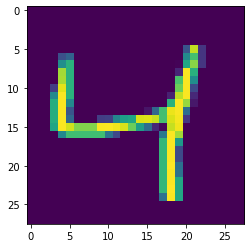

In [6]:
sample = x_train[2]
plt.imshow(sample.squeeze(axis=2))

In [7]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [8]:
#predictions = [np.argmax(model(tf.expand_dims(sample, axis=0)).numpy()) for i in range(100)]
predictions = [model(tf.expand_dims(sample, axis=0)).numpy() for i in range(100)]
#predictions = [probability_model(tf.expand_dims(x_train[0], axis=0)).numpy() for i in range(100)]

In [9]:
predictions

[array([[ 62137.74  ,  -9905.575 ,  -4966.707 ,  -1445.9119,  -3698.9268,
         -14180.119 ,  -4875.5874,  -3202.0793, -10635.603 , -13422.831 ]],
       dtype=float32),
 array([[ 48619.348 ,   2132.6812,  -3202.3103,  -5828.505 ,  -7436.3833,
         -17651.203 ,  -2815.2922, -11026.191 ,  -5724.2646,   7349.1006]],
       dtype=float32),
 array([[ 58043.293 ,  -6383.2466,   5727.228 ,  10080.651 ,    740.1539,
          -1226.2123,  -7573.1104, -17588.361 , -10598.856 ,   6878.0356]],
       dtype=float32),
 array([[ 22930.832 ,  -6366.8086,   2059.0898, -14503.343 ,  -5961.2705,
           7629.6455,  -5423.7407, -15887.922 , -12979.01  ,  -5510.3076]],
       dtype=float32),
 array([[ 37872.094 ,  13187.594 ,   9071.338 ,   5235.4746, -13280.008 ,
         -12739.686 , -20018.266 ,   1763.6632, -16628.777 ,  -7623.144 ]],
       dtype=float32),
 array([[ 27855.412  , -22696.678  ,   3522.0435 ,  -9453.954  ,
         -15097.062  ,  -9162.572  ,  -3121.8542 ,  -9797.582  ,
     